<a href="https://colab.research.google.com/github/panxiaofan/Advanced-Mahchine-Perception/blob/master/CIS680_Fall2020_HW1_b_Q4.2_Answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'

In [4]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='../content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2020')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW1')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

Drive already mounted at ../content/gdrive; to attempt to forcibly remount, call drive.mount("../content/gdrive", force_remount=True).


# PyTorch

This code block imports torch and torchvision which provide the libraries for use down below. PyTorch provides many utilities such as standard datasets, for this exercise we will use MNIST. Please see the torchvision documentation for how to instantiate the training and testing data split.

In [6]:
# torch and torchvision imports
import torch
import torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# 3) Train a Convolutional Neural Network

In [8]:
# Create your network here
class HelloWorld(torch.nn.Module):
  def __init__(self):
    super(HelloWorld, self).__init__()
    self.layer1 = nn.Sequential()                                        # 28 *28 *1
    self.layer1.add_module("Conv1", nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))   # 28 *28 *32
    self.layer1.add_module("BN1", nn.BatchNorm2d(num_features=32))
    self.layer1.add_module("Relu1", nn.ReLU())
    self.layer1.add_module("Pool1", nn.AvgPool2d(kernel_size=2, stride=2, padding=0))             # 14 *14 *32 
                                                 
    self.layer2 = nn.Sequential()   
    self.layer2.add_module("Conv2", nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2))  # 14 *14 *32
    self.layer2.add_module("BN2", nn.BatchNorm2d(num_features=32))
    self.layer2.add_module("Relu2", nn.ReLU())
    self.layer2.add_module("Pool2", nn.AvgPool2d(kernel_size=2, stride=2, padding=0))            # 7 *7 *32

    self.layer3 = nn.Sequential()
    self.layer3.add_module("Conv3", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))  # 7 *7 *64
    self.layer3.add_module("BN3", nn.BatchNorm2d(num_features=64))
    self.layer3.add_module("Relu3", nn.ReLU())
    self.layer3.add_module("Pool3", nn.AvgPool2d(kernel_size=2, stride=2, padding=0))         # 3 *3 *64

    self.fully_connected1 = nn.Sequential()
    self.fully_connected1.add_module("FC1", nn.Linear(in_features=3 * 3 * 64, out_features=64))  
    self.fully_connected1.add_module("BNFC1", nn.BatchNorm1d(64))
    self.fully_connected1.add_module("ReluFC1", nn.ReLU())

    self.fully_connected2 = nn.Sequential()
    self.fully_connected2.add_module("FC2", nn.Linear(in_features=64, out_features=10))
    self.fully_connected2.add_module("SoftMax", nn.Softmax())

  
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = x.view(-1, 3 * 3 * 64)
    x = self.fully_connected1(x)
    x = self.fully_connected2(x)
    return x
  

In [11]:
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='.', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='.', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [12]:
def train(epoch):
    my_first_network.train()
    running_loss = 0
    running_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = my_first_network(data)
        loss = error(output, target) 
        running_loss += loss.item() * data.size(0)
        loss.backward()
        optimizer.step()
        predicted = torch.max(output.data, 1)[1] 
        running_correct += (predicted == target).sum()
        if batch_idx % display_interval == 0:
          print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(data), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.item(), float(running_correct*100) / float(batch_size_train*(batch_idx + 1))))
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accu = float(running_correct) / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accu)
    print('\nTrain set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch_loss, running_correct, len(train_loader.dataset),
        100. * running_correct / len(train_loader.dataset)))


In [20]:
def test(epoch):
  my_first_network.eval()
  running_loss = 0
  running_correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = my_first_network(data)
      running_loss += error(output, target).item()* data.size(0)
      predicted = torch.max(output.data, 1)[1] 
      running_correct += (predicted == target).sum()
  epoch_loss = running_loss / len(test_loader.dataset)
  epoch_accu = float(running_correct) / len(test_loader.dataset)
  test_losses.append(epoch_loss)
  test_accuracy.append(epoch_accu)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    epoch_loss, running_correct, len(test_loader.dataset),
    100. * running_correct / len(test_loader.dataset)))
  is_new_best(epoch_accu)

In [21]:
def is_new_best(epoch_accu):
  if (epoch_accu > 0.99 and epoch_accu == max(test_accuracy)):
    PATH = HOMEWORK_FOLDER+'/pre-trained model'
    torch.save(my_first_network.state_dict(), PATH)

In [ ]:
# Instantiate your network here
torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_first_network = HelloWorld().to(device)
learning_rate = 0.002
optimizer = torch.optim.Adam(my_first_network.parameters(),lr=learning_rate)
error = nn.CrossEntropyLoss()
display_interval = 50
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
# Train your network here
num_epochs = 5
for epoch in range(num_epochs):
  train(epoch)
  test(epoch)

**Training & Testing Loss**

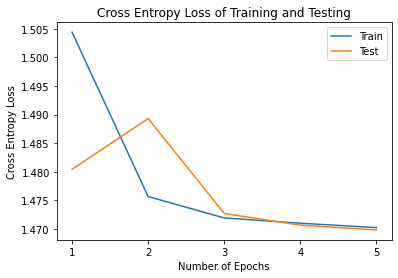

In [23]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(1, num_epochs + 1), np.array(train_losses))
plt.plot(np.arange(1, num_epochs + 1), np.array(test_losses))
plt.legend(['Train','Test'], loc='upper right')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.xticks(range(1,num_epochs + 1))
plt.title('Cross Entropy Loss of Training and Testing')
plt.savefig(HOMEWORK_FOLDER+'/Cross Entropy Loss of Training and Testing.png')
plt.show()

**Training & Testing Accuracy**

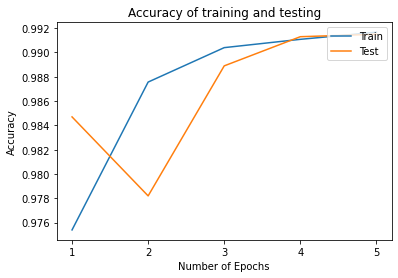

In [24]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(1, num_epochs + 1), np.array(train_accuracy))
plt.plot(np.arange(1, num_epochs + 1), np.array(test_accuracy))
plt.legend(['Train','Test'], loc='upper right')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1,num_epochs + 1))
plt.title('Accuracy of training and testing')
plt.savefig(HOMEWORK_FOLDER+'/Accuracy of training and testing.png')
plt.show()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
PATH = HOMEWORK_FOLDER+'/pre-trained model'
model = HelloWorld()
model.load_state_dict(torch.load(PATH))
model.to(device)

running_loss = 0
running_correct = 0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    running_loss += error(output, target).item()* data.size(0)
    predicted = torch.max(output.data, 1)[1] 
    running_correct += (predicted == target).sum()
epoch_loss = running_loss / len(test_loader.dataset)
epoch_accu = float(running_correct) / len(test_loader.dataset)

print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  epoch_loss, running_correct, len(test_loader.dataset),
  100. * running_correct / len(test_loader.dataset)))
is_new_best(epoch_accu)

In [13]:
# epsilons = [0, .05, .1, .15, .2, .25, .3]

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='.', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Set the model in evaluation mode. In this case this is for the Dropout layers
PATH = HOMEWORK_FOLDER+'/pre-trained model'
model = HelloWorld().to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

CUDA Available:  True


HelloWorld(
  (layer1): Sequential(
    (Conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Relu1): ReLU()
    (Pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer2): Sequential(
    (Conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (BN2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Relu2): ReLU()
    (Pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (Conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (BN3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Relu3): ReLU()
    (Pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fully_connected1): Sequential(
    (FC1): Linear(in_features=576, out_features=64, bias=True)
    (BNFC1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=

In [112]:
def fgsm_attack(input_image, epsilon, perturbation_grad, perturbation):
    sign_perturbation_grad = torch.sign(perturbation_grad.data)
    sign_perturbation_grad = torch.clamp(sign_perturbation_grad, min = 0, max = 1)
    perturbation.data += epsilon * sign_perturbation_grad
    perturbed_image = input_image +  perturbation.data
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    perturbation.data = perturbed_image - input_image
    return perturbation

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(2)


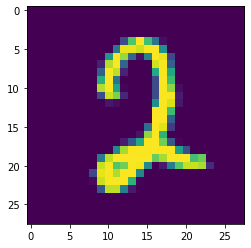

loss: tensor(1.4612, device='cuda:0', grad_fn=<NllLossBackward>)predict: tensor(2)
tensor(8)


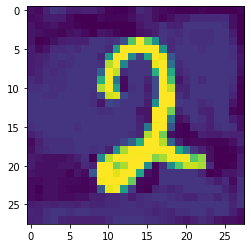

tensor(6)


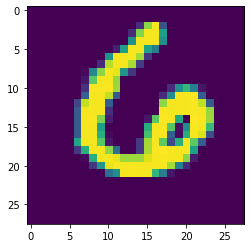

loss: tensor(1.4612, device='cuda:0', grad_fn=<NllLossBackward>)predict: tensor(6)
tensor(0)


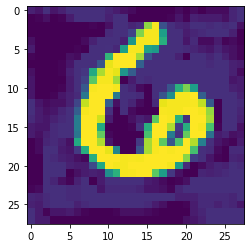

<Figure size 432x288 with 0 Axes>

In [118]:
  fig = plt.figure()
  for i in range(2):  
    test_iterator=iter(test_loader)
    test_images, test_labels=test_iterator.next()
    test_images, test_labels=test_images.to(device), test_labels.to(device)
    output = model(test_images)
    predicted = torch.max(output.data, 1)[1] 
    print(predicted[0].cpu())
    orig_images=test_images.detach().cpu()
    orig_images = np.squeeze(orig_images)
    plt.imshow(orig_images)
    plt.savefig(HOMEWORK_FOLDER+'/No.'+ str(i)+' original test_image.png')
    plt.show()
    # Accuracy counter
    epsilon = 0.03
    num_training_episode = 100000
    data = test_images
    target = test_labels
    model.eval()

    # Send the data and label to the device
    data, target = data.to(device), target.to(device)
    perturbation = torch.zeros(data.shape).to(device)

    # Set requires_grad attribute of tensor. Important for Attack
    # data.requires_grad = True
    perturbation.requires_grad = True
    # Forward pass the data through the model
    output = model(data + perturbation)
    predicted = torch.max(output.data, 1)[1]  # get the index of the max log-probability

    # If the initial prediction is wrong, dont bother attacking, just move on
    if predicted.item() == target.item():
      for j in range(num_training_episode):
          # Calculate the loss
          loss = error(output, target)
          if j % 1000 == 1:
            print("loss: " + str(loss) + "predict: " + str(predicted[0].cpu()))
          # Zero all existing gradients
          model.zero_grad()

          # Calculate gradients of model in backward pass
          loss.backward()

          # Collect datagrad
          perturbation_grad = perturbation.grad.data
          # print(np.squeeze(perturbation_grad))

          # Call FGSM Attack
          perturbation = fgsm_attack(data, epsilon, perturbation_grad, perturbation)
          

          # Re-classify the perturbed image
          output = model(data + perturbation)
          perturbation.grad.zero_()
          predicted = torch.max(output.data, 1)[1]
          if predicted.item() != target.item() and torch.max(output.data)>= 0.9:
            print(predicted[0].cpu())
            final_perturbed_image = (data + perturbation).detach().cpu()
            final_perturbed_image = np.squeeze(final_perturbed_image)
            plt.imshow(final_perturbed_image)
            plt.show() 
            plt.savefig(HOMEWORK_FOLDER+'/No.'+ str(i)+' perturbed test_image.png')
            break


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(1)


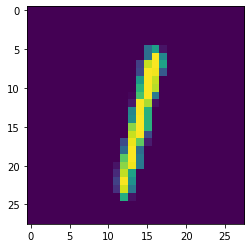

In [158]:
  test_iterator=iter(test_loader)
  test_images, test_labels=test_iterator.next()
  test_images, test_labels=test_images.to(device), test_labels.to(device)
  output = model(test_images)
  predicted = torch.max(output.data, 1)[1] 
  print(predicted[0].cpu())
  orig_images=test_images.detach().cpu()
  orig_images = np.squeeze(orig_images)
  plt.imshow(orig_images)
  plt.savefig(HOMEWORK_FOLDER+'/No.'+ str(3)+' original test_image.png')
  plt.show()
 

In [120]:
test_labels

tensor([0], device='cuda:0')

In [121]:
def fgsm_attack(input_image, epsilon, perturbation_grad, perturbation):
    sign_perturbation_grad = torch.sign(perturbation_grad.data)
    sign_perturbation_grad = torch.clamp(sign_perturbation_grad, min = 0, max = 1)
    perturbation.data += epsilon * sign_perturbation_grad
    perturbed_image = input_image +  perturbation.data
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    perturbation.data = perturbed_image - input_image
    return perturbation

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss: tensor(18.6892, device='cuda:0', grad_fn=<SubBackward0>)predict: tensor(1)
tensor(3)


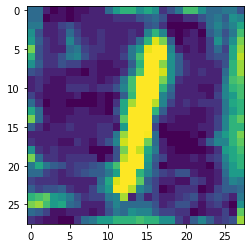

<Figure size 432x288 with 0 Axes>

In [178]:
  # Accuracy counter
  epsilon = 0.1
  num_training_episode = 100000
  data = test_images
  y_truth = test_labels
  target = torch.tensor([3])
  model.eval()
  model.to(device)

  # Send the data and label to the device
  data, target = data.to(device), target.to(device)
  perturbation = torch.zeros(data.shape).to(device)

  # Set requires_grad attribute of tensor. Important for Attack
  # data.requires_grad = True
  perturbation.requires_grad = True
  # Forward pass the data through the model
  output = model(data + perturbation)
  predicted = torch.max(output.data, 1)[1]  # get the index of the max log-probability

  # If the initial prediction is wrong, dont bother attacking, just move on
  for j in range(num_training_episode):
      # Calculate the loss
      loss = (error(output, y_truth)
        + error(output, torch.tensor([2]).to(device))+error(output, torch.tensor([4]).to(device))+ error(output, torch.tensor([5]).to(device))
        + error(output, torch.tensor([6]).to(device))+ error(output, torch.tensor([7]).to(device))
        + error(output, torch.tensor([8]).to(device))+ error(output, torch.tensor([9]).to(device))+ error(output, torch.tensor([0]).to(device))
        - error(output, target) )
      if j % 1000 == 1:
        print("loss: " + str(loss) + "predict: " + str(predicted[0].cpu()))
      # Zero all existing gradients
      model.zero_grad()

      # Calculate gradients of model in backward pass
      loss.backward()

      # Collect datagrad
      perturbation_grad = perturbation.grad.data
      # print(np.squeeze(perturbation_grad))

      # Call FGSM Attack
      perturbation = fgsm_attack(data, epsilon, perturbation_grad, perturbation)
      perturbation.grad.zero_()
      

      # Re-classify the perturbed image
      output = model(data + perturbation)
      
      predicted = torch.max(output.data, 1)[1]
      if predicted.item() == target.item():
        print(predicted[0].cpu())
        final_perturbed_image = (data + perturbation).detach().cpu()
        final_perturbed_image = np.squeeze(final_perturbed_image)
        plt.imshow(final_perturbed_image)
        plt.show() 
        plt.savefig(HOMEWORK_FOLDER+'/No.'+ str(3)+' perturbed test_image.png')
        break
